## 1. A description of the problem and a discussion of the background.

### Scenario:

Currently I live in Amsterdam where is the captical city in Netherlands and everyday I need to drive more than oen hour to my work(Rotterdam)where is on the other side of the country.Traffic jams in Netherlands increases during both the morning and evening rush hour as well as during the day. In order to save commuting time, I decide to relocate to a new neighbourhood where is also close to my office. The queation is: I would like to find a cosy and convenient place similar to my currect house. Since I will move together with my family, the new place would be most desirable in the neighbourhood with sport center, school supermarkets and restaurants. 

Some requirements are shown as below before I can finally make a comparison and evaluation of the new place to live:

 * house must have al least 4 rooms and garden
 * house price is between 300.000 and 350.000 euro
 * desirable to have venues such as coffee shops, restaurants,gym and food shops,schools
 * the selected neighborhood shall be similar to current residence

## Business Problem

The netherlands is a small country but with high-density population, the house price has been dramaticlly increased in the last few years especially in the area of randstad. Therefore it is always a big challenge for renting/buying in big cities such as Amsterdam, Rotterdam, Den Haag and Utrecht. The final goal of this project is aim to find a suitable neighbourhood with demands on location, price and environment, which has similarities as the currect living.

# 2. A description of the data and how it will be used to solve the problem

## Data section

The following data is required for solving this problem:
  
  * List of available houses in Rotterdam with address and price
  * List of boroughs and neighbourhood of Rotterdam with its geodata
  * List of schools in Rotterdam with location 
  * Venues of each desired neighbourhood and stations

## 3. Methodology section:
### How the data can be used to solve the problem

  * Use Foursquare and geopy data to map top 10 venues for all Rotterdam neighborhoods and clustered in groups 
  * Use foursquare and geopy data to map the location of bus stations , separately and on top of the above clustered map in order to be able to identify the venues near each station, or explore each subway location separately
  * Use Foursquare and geopy data to map the location of houses. 
  * Addresses from houses will be converted to geodata( latitude, longtitude) using Geopy-distance and Nominatim.


The procesing of these DATA will allow to answer the key questions to make a decision:

 * what is the cost of house(per square meter) around a specific radius from each station?
 * what is the area of Rotterdam with best house pricing that meets criteria established?
 * What is the distance between the work place and the tentative future home?
 * What are the venues of the two best places to live? How the prices compare?
 * How venues distribute among Rotterdam neighborhoods and around supermarkets?
 * Are there tradeoffs between size and price and location?


### Reference of venues around current residence in Amsterdam for comparison to Rotterdam 

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


In [3]:
CLIENT_ID = 'CP5 *****************BU' # your Foursquare ID
CLIENT_SECRET = 'TA****************1C' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
 

In [4]:
address = 'Rijnstraat, Amsterdam, NL'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

52.3406123 4.9072881


In [5]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=CP5HSTNJ4NMVZWJAYXRX24GHVPSWHSKJZ1MR5WSCY1DHGCBU&client_secret=TAJQ5VGIEYJOGBLGN2UEDOT0HYRGC4PZQV3ZGTAXS4VIMG1C&v=20180604&ll=52.3406123,4.9072881&radius=1000&limit=100'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec5139b69babe0028b5b2f4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rijnbuurt',
  'headerFullLocation': 'Rijnbuurt, Amsterdam',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 97,
  'suggestedBounds': {'ne': {'lat': 52.34961230900001,
    'lng': 4.9219913800128126},
   'sw': {'lat': 52.331612290999985, 'lng': 4.892584819987187}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc8a2bb15a7ef3b38847bda',
       'name': 'IJssalon IJspret',
       'location': {'address': 'Rijnstraat 184',
        'lat': 52.342430434152654,
        'lng': 4.906680125415919,
        'labeledLatLngs': [{'label': 'display',
          'lat': 52.

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
 

In [10]:
venues = results['response']['groups'][0]['items']
    
AMSnearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
AMSnearby_venues =AMSnearby_venues.loc[:, filtered_columns]

# filter the category for each row
AMSnearby_venues['venue.categories'] = AMSnearby_venues.apply(get_category_type, axis=1)

# clean columns
AMSnearby_venues.columns = [col.split(".")[-1] for col in AMSnearby_venues.columns]

AMSnearby_venues.head(10)

,name,categories,lat,lng
0,IJssalon IJspret,Ice Cream Shop,52.342430,4.906680
1,De Parade,Circus,52.340436,4.910966
2,Thuis aan de Amstel,Café,52.339639,4.914769
3,Kong Kha,Thai Restaurant,52.345182,4.905655
4,De Mirandabad,Pool,52.338856,4.901854
5,Eatalia Gastronomia,Deli / Bodega,52.342951,4.906738
6,Fixables,Electronics Store,52.342474,4.906724
7,Betty's,Vegetarian / Vegan Restaurant,52.345541,4.905541
8,Alles Voor De Lunch,Breakfast Spot,52.343097,4.907701
9,Hi-Fi Klubben,Electronics Store,52.343084,4.906362


In [12]:
# create map of Singapore place  using latitude and longitude values
map_AMS = folium.Map(location=[latitude, longitude], zoom_start=20)

# add markers to map
for lat, lng, label in zip(AMSnearby_venues['lat'], AMSnearby_venues['lng'], AMSnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=4,
        radius=10,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.7,
    ).add_to(map_sg)  
    
map_AMS

# 3. Methodoloy Execution - Mapping Data
### Rotterdam map

In [33]:
address = 'Stationsplein, Rotterdam, Netherlands'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rotterdam {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Rotterdam 51.9234192, 4.469304364562113.


C:\Users\run\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [34]:
R_latitude=51.9234192
R_longitude=4.469304364562113

In [35]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    R_latitude, 
    R_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=CP5HSTNJ4NMVZWJAYXRX24GHVPSWHSKJZ1MR5WSCY1DHGCBU&client_secret=TAJQ5VGIEYJOGBLGN2UEDOT0HYRGC4PZQV3ZGTAXS4VIMG1C&v=20180604&ll=51.9234192,4.469304364562113&radius=3000&limit=100'

In [36]:
results = requests.get(url).json()
results
# define the dataframe columns
 

{'meta': {'code': 200, 'requestId': '5ec56d0a77af03001b42e086'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rotterdam',
  'headerFullLocation': 'Rotterdam',
  'headerLocationGranularity': 'city',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 51.950419227000026,
    'lng': 4.5130030764888875},
   'sw': {'lat': 51.89641917299997, 'lng': 4.425605652635339}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae19cc4f964a520678621e3',
       'name': 'Station Rotterdam Centraal',
       'location': {'address': 'Stationssingel 10',
        'lat': 51.92482915893511,
        'lng': 4.469401014536617,
        'distance': 157,
        'postalCode': '3013 HA',
        'cc': 'N

In [43]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [38]:
venues = results['response']['groups'][0]['items']
ROMnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
ROMnearby_venues =ROMnearby_venues.loc[:, filtered_columns]
# filter the category for each row
ROMnearby_venues['venue.categories'] = ROMnearby_venues.apply(get_category_type, axis=1)
# clean columns
ROMnearby_venues.columns = [col.split(".")[-1] for col in ROMnearby_venues.columns]



(100, 4)

In [22]:
ROMnearby_venues.head(10)

,name,categories,lat,lng
0,Schmidt Zeevis,Fish Market,51.925349,4.416819
1,LUCAS Drinkwinkel,Bar,51.918243,4.398192
2,Euroscoop,Multiplex,51.923825,4.406285
3,RKSV Excelsior'20,Soccer Field,51.930061,4.393604
4,Yokohama Ramen Saito,Ramen Restaurant,51.920489,4.395918
5,Zegro,Big Box Store,51.932531,4.412422
6,Záálig Eten & Drinken,Diner,51.918253,4.398506
7,Hamachi,Japanese Restaurant,51.913404,4.400028
8,Antep Pastanesi,Bakery,51.934333,4.410842
9,Dirk van den Broek,Supermarket,51.915868,4.401264


In [41]:
map_ROM = folium.Map(location=[R_latitude, R_longitude], zoom_start=10)
# add markers to map
for lat, lng, label in zip(ROMnearby_venues['lat'], ROMnearby_venues['lng'], ROMnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=5,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_ROM)  
    
map_ROM

### Using KMeans clustering for the clsutering of the neighbourhoods

In [42]:
ROMnearby_venues.head(10)

,name,categories,lat,lng
0,Station Rotterdam Centraal,Train Station,51.924829,4.469401
1,Lebkov & Sons Rotterdam,Sandwich Place,51.923679,4.469122
2,Rotterdam Marriott Hotel,Hotel,51.922414,4.471624
3,Miniworld Rotterdam,Museum,51.922658,4.464797
4,Amazing Oriental 東方行,Supermarket,51.920560,4.469794
5,Bertmans,Vegetarian / Vegan Restaurant,51.920812,4.474312
6,Booon,Café,51.927156,4.472730
7,Rotterdam Biergarten,Beer Garden,51.925565,4.476143
8,De IJssalon,Ice Cream Shop,51.920172,4.467403
9,KINO,Movie Theater,51.917176,4.469214


In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
rotterdam_venues = getNearbyVenues(names=ROMnearby_venues['name'],
                                   latitudes=ROMnearby_venues['lat'],
                                   longitudes=ROMnearby_venues['lng']
                                  )


Station Rotterdam Centraal
Lebkov & Sons Rotterdam
Rotterdam Marriott Hotel
Miniworld Rotterdam
Amazing Oriental 東方行
Bertmans
Booon
Rotterdam Biergarten
De IJssalon
KINO
Op het Dak
YoYo! Fresh Tea Bar
Urban Residences Rotterdam
Kaapse Maria
The James
Jordy's Bakery
FG Food Labs
Weena
The SUE Store
Man met Bril Koffie
Le Nord
Sugo
Decathlon
Restaurant De Jong
Panini
Koekela
Angelo Betti
De IJssalon
Lilith Coffee
Japanese Cuisine Yama
De IJsmaker
Little Italy
Buiten
Huis Sonneveld
Guliano
Pomms'
Mr Nonno
Lush
Stadsbrouwerij Thoms
Museum Boijmans Van Beuningen
Rotown
Museumpark
Funkie House
Asha
Hopper Coffee & Bakery
Oude hoofdentree Diergaarde Blijdorp
Hamburg
THOMS
Filo-Filo
Spirit
Vroesenpark
Markthal
Little V
Kaaspaleis
Pleinbioscoop Rotterdam
Backyard
ace & tate
Harvest Coffee Brewers
Walenburg
Bokaal
Boguette
De Huismeester
Kookpunt
Rotterdamse Centrummarkt
Panzero
Juffrouw Van Zanten West
Vlaamsch Broodhuys
Rotterdam Centrum
Picknick
Giraffen
Mainport Hotel
Foodelicious
De Groene 

### Map of houses in the neighbourhood of Rotterdam

#### From https://www.funda.nl/ all required data are collected and saved as csv file. 

In [84]:
# csv files with rental places with basic data but still wihtout geodata ( latitude and longitude)
# pd.read_csv(' le.csv', header=None, nrows=5)
ro_house=pd.read_csv('Rotterdam_house.csv')
ro_house.head()

,Address,Post Code,Rooms,Area_ft2,Price,lat,Long
0,Symfonielaan,3208 SE,5,98,"257,500.00 €",NaN,NaN
1,Edelweisslaan,3053 JE,6,152,"560,000.00 €",NaN,NaN
2,Van Enckevoirtlaan,3052 KR,7,132,"550,000.00 €",NaN,NaN
3,Laan van Wateringse,2548 CR,5,141,"450,000.00 €",NaN,NaN
4,Couperinstraat,2901 RA,5,121,"380,000.00 €",NaN,NaN


#### Obtain geodata for each house in Rotterdam with nominatim 

In [74]:
for n in range(len(ro_house)):
 address = ro_house['Address'][n] 
 address=(ro_house['Address'][n]+ ' , '+' Rotterdam NL ') 
 geolocator = Nominatim() 
 location = geolocator.geocode(address) 
if location is not None and location.longitude is not None:
    latitude = location.latitude 
    longitude = location.longitude 
    ro_house['lat'][n]=latitude 
    ro_house['Long'][n]=longitude

print(n,latitude,longitude)

C:\Users\run\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


44 51.9234192 4.469304364562113


In [75]:
ro_house.head()

,Address,Post Code,Rooms,Area_ft2,Price,lat,Long
0,Symfonielaan,3208 SE,5,98,"257,500.00 €",NaN,NaN
1,Edelweisslaan,3053 JE,6,152,"560,000.00 €",NaN,NaN
2,Van Enckevoirtlaan,3052 KR,7,132,"550,000.00 €",NaN,NaN
3,Laan van Wateringse,2548 CR,5,141,"450,000.00 €",NaN,NaN
4,Couperinstraat,2901 RA,5,121,"380,000.00 €",NaN,NaN


In [81]:
ro_house.to_csv('Rotterdam_house.csv',index=False)

In [88]:
ro_house=pd.read_csv('Rotterdam_house.csv')
ro_house.head()

,Address,Post Code,Rooms,Area_ft2,Price,Lat,Long
0,Symfonielaan,3208 SE,5,98,257500,51.799771,4.533787
1,Edelweisslaan,3053 JE,6,152,560000,51.788585,4.544723
2,Van Enckevoirtlaan,3052 KR,7,132,550000,51.799771,4.533787
3,Laan van Wateringse,2548 CR,5,141,450000,51.730523,4.498127
4,Couperinstraat,2901 RA,5,121,380000,51.744118,4.504701


#### Rotterdam house price statistics

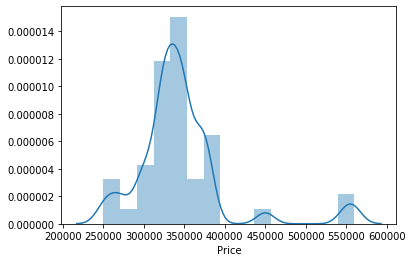

In [89]:
import seaborn as sns
sns.distplot(ro_house['Price'],bins=15)

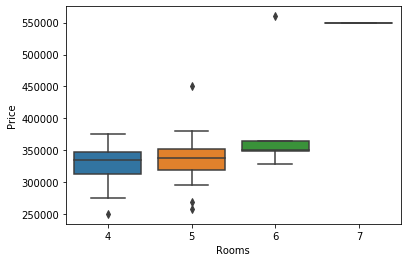

In [91]:
sns.boxplot(x='Rooms', y= 'Price', data=ro_house)

### Map of houses in the neighbourhood of Rotterdam

In [93]:
# create map of Rotterdam using latitude and longitude values from Nominatim
latitude= 51.9234192
longitude= 4.469304364562113

map_rotterdam = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(ro_house['Lat'], ro_house['Long'],'$ ' + ro_house['Price'].astype(str)+ ',  '+ ro_house['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rotterdam) 
    
map_rotterdam

### 4. Results

In [96]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 51.9234192
longitude= 4.469304364562113

map_ro_one = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(ro_house['Lat'], ro_house['Long'],'$ ' + ro_house['Price'].astype(str)+ ', '+ro_house['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ro_one) 
    
   


In [98]:

## kk is the cluster number to explore
kk = 2
ro_house.loc[ro_house['Post Code'] == kk, ro_house.columns[[1] + list(range(5, ro_house.shape[1]))]]

,Post Code,Lat,Long


In [101]:
from matplotlib import cm
import matplotlib.colors as colors
latitude= 51.9234192
longitude= 4.469304364562113

# create map with clusters
kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


In [102]:
# add markers to map for rental places
for lat, lng, label in zip(ro_house['Lat'], ro_house['Long'],' € ' + ro_house['Price'].astype(str)+ ro_house['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters) 

In [104]:
# Adds tool to the top right
from folium.plugins import MeasureControl
map_rotterdam.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_rotterdam)

map_clusters

### Solution Select the house that fulfill the requirements

#### The above consolidate map was used to explore options for finding a nice house. After examning, I have chosen two houses that meet the requirements:
 * House 1: 3025 BJ, Cluster 2
 * House 2: 2651 PC, Cluster 3
 
The prices of those two are between 300.000 and 350.000 euro and have at least 5 rooms.

In [110]:
ro_house1=pd.read_csv('Rotterdam_merged.csv')
ro_house1.head()
 

,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Unnamed: 15,Unnamed: 16
0,Rotterdam,3208 SE,51.976551,4.539340,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant,NaN,NaN
1,Rotterdam,3053 JE,51.976551,4.455721,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop,NaN,NaN
2,Rotterdam,3052 KR,51.976551,4.513100,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant,NaN,NaN
3,Rotterdam,2548 CR,51.976551,4.528790,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant,NaN,NaN
4,Rotterdam,2901 RA,51.976551,4.500312,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio,NaN,NaN


#### Venues for house1

In [112]:

## kk is the cluster number to explore
kk = 2
ro_house1.loc[ro_house1['Cluster Labels'] == kk, ro_house1.columns[[1] + list(range(5, ro_house1.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Unnamed: 15,Unnamed: 16
0,3208 SE,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant,NaN,NaN
1,3053 JE,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop,NaN,NaN
6,3191 GM,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center,NaN,NaN
9,3025 BJ,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub,NaN,77.95
14,2641 LK,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater,NaN,NaN
23,3208 SH,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio,NaN,NaN
26,2992 KK,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court,NaN,NaN
34,3124 CN,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant,NaN,NaN
39,3131 ES,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym,NaN,NaN


#### Venues for house 2

In [113]:
## kk is the cluster number to explore
kk = 3
ro_house1.loc[ro_house1['Cluster Labels'] == kk, ro_house1.columns[[1] + list(range(5, ro_house1.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Unnamed: 15,Unnamed: 16
3,2548 CR,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant,NaN,NaN
5,2665 ES,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife,NaN,NaN
10,2548 TL,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant,NaN,0.5
12,2548 TL,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant,NaN,NaN
16,2652 CC,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant,NaN,NaN
17,2651 PC,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel,NaN,NaN
18,3066 GK,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Café,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store,NaN,NaN
27,3121 VC,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop,NaN,NaN
29,2651 EB,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center,NaN,NaN
31,2991 KD,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop,NaN,NaN


### House selection

Using the map above, I was able to explore all possibilities since the popups provide the information needed for a good decision.
House 1 rent cost is ER340.000 slightly below the EU350.000 budget. Venues for this apt are as of Cluster 2 and it is located in a fine district in the East side of Rotterdam.

House 2 cost is EU325.000, a bit cheaper than house 1 but also a bit smaller. Venues for this apt are as of Cluster 3.

Based on current Amsterdam venues, I feel that Cluster 3  type of venues is a closer resemblance to my current place. That means that House 1 is a better choice since the extra house cost is worth the conveniences it provides.

# 5. Discussion

In general, I am positively impressed with the overall organization, content and lab works presented during the Coursera IBM Certification Course
I feel this Capstone project presented me a great opportunity to practice and apply the Data Science tools and methodologies learned.
I have created a good project that I can present as an example to show my potential.


# 6.0 Conclusions
I feel rewarded with the efforts, time and money spent. I believe this course with all the topics covered is well worthy of appreciation.
This project has shown me a practical application to resolve a real situation that has impacting personal and financial impact using Data Science tools.
The mapping with Folium is a very powerful technique to consolidate information and make the analysis and decision thoroughly and with confidence. I would recommend for use in similar situations.
